In [15]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from matplotlib import pyplot as plt

## Skup podataka i vizuelizacija

<div style="text-align: justify"> Skup podataka sa kojim radimo naziva se <em>hetrec2011-lastfm-2k</em> i sadrži 
informacije o popularnosti muzičkih izvođača po njihovoj slušanosti od strane korisnika, društvenoj mreži korisnika,
kao i rejtinzima i žanrovima koje su korisnici dodijelili izvođačima na onlajn muzičkoj platformi <em>Last.fm</em>.
Baza podataka je objavljena u okviru druge međunarodne radionice o heterogenosti informacija i fuzije u sistemima preporuka (HetRec 2011). </div>

### Sadržaj skupa podataka

Skup podataka sastoji se od šest datoteka:
* **artists.dat**   
    Fajl sadrži informacije o izvođačima koje su korisnici slušali i kojima su dodijelili odgovarajući tag žanra muzike. 
* **tags.dat**   
    Fajl sadrži skup svih mogućih tagova (žanrova muzike) dostpunih u skupu podataka.
* **user_artists.dat**    
    Fajl sadrži skup izvođača slušanih od strane korisnika. Takođe, sadrži i informaciju o dužini slušanja (kolona 'weight') za svaki [korisnik, izvođač] par. 
* **user_tagged_artists.dat**    
    Fajl sadrži informaciju o tagovima (žanrovima muzike) koji su korisnici dodijelili slušanim izvođačima.
* **user_tagged_artists-timestamps.dat**    
    Fajl je modifikacija prethodno navedenog u kom je dodata informacija o vremenskom trenutku kada je tag (žanr muzike) dodijeljen. 
        
* **user_friends.dat**    
    Fajl sadrži informaciju o društvenoj mreži korisnika, odnosno vezu između korisnika i njegovih prijatelja na muzičkoj platformi. 
    

### Format podataka

<div style="text-align: justify"> Podaci su organizovani u formi jednog unosa po redu i u svakom redu su razdvojeni tabulatorom "\t". Na primjer, fajl <em> user_artists.dat</em>  je formairan kao <br/> userID \t artistID \t weight. Analogno za ostale fajlove u skupu podataka.

<b>Napomena:</b><br>    Da bi se smanjila memorijska i vremenska složenost treniranja modela, izdvojen je podskup od hiljadu najslušanijih izvođača na muzičkoj platformi <em>Last.fm.</em>
</div>

### Vizuelizacija podatka
U svrhu detaljnije analize podataka, potrebno je da ih prvo učitamo i vizuelizujemo. Za učitavanje podataka koristimo funkciju <em> read_excel</em>  biblioteke <em> pandas</em> . Podaci se učitavaju iz tri fajla. Prvo učitavamo podatke o korisnicima i izvođačima koje su slušali, a potom izdvajamo hiljadu najpopularnijih izvođača. 

In [16]:
df_user_artists1 = pd.read_excel('baza/user_artists.xlsx')
artistID, rate_frequency_artist = np.unique(df_user_artists1['artistID'], return_counts=True)
artist_rate_frequency = pd.DataFrame({'artistID': artistID, 'rate_frequency_artist': rate_frequency_artist})
artist_rate_frequency.sort_values(by='rate_frequency_artist', ascending=False, inplace=True)
most_frequent_artists = artist_rate_frequency[:1000]
df_user_artists = df_user_artists1[df_user_artists1['artistID'].isin(most_frequent_artists['artistID'])]

# Prikaz prvih 5 instanci skupa podataka.
df_user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [17]:
# Učitavanje podataka o korisnicima i njihovim prijateljima.
df_user_friends = pd.read_excel('baza/user_friends.xlsx')    

In [18]:
# Učitavanje podataka o tagovima koje su korisnici dodijelili izvođačima.
df_user_tagged_artists = pd.read_excel('baza/user_tagged_artists.xlsx')

In [19]:
# Broj jedinstvenih korisnika i izvođača redom, broj dodijeljenih rejtinga. Izvođači su označeni sa items.
users = df_user_artists.drop_duplicates(subset='userID')
n_users = len(users)
n_items = len(most_frequent_artists)
ratings = len(df_user_artists)
print(f"users, items, ratings:", n_users, n_items, ratings)

users, items, ratings: 1871 1000 56620


In [20]:
# Gustina dodjeljivanja rejtina (predstavlja mjeru koliko dodijeljenih rejtinga imamo po korisniku). 
# Uočavamo da je gustina dodjeljivanja rejtinga mala. 
rating_density = "{:.1%}".format(n_users/ratings)
print(f"rating_density: ", rating_density)

rating_density:  3.3%


In [21]:
# Izdvajamo korisnike i njihove prijatelje koji se nalaze u skupu prethodno izdvojenih 
# korisnika koji su dodijelili rejting za hiljadu najfrekventinijih izvođača. 
df_relations=df_user_friends[df_user_friends['userID'].isin(users['userID'])]
n_relations = len(df_relations)
print(f"Broj poveznica između korisnika i njihovih prijatelja: ", n_relations)

Broj poveznica između korisnika i njihovih prijatelja:  25296


In [22]:
# Određujemo broj tagova koji su pridruženi odabranim izvođačima. 
df_artist_tags=df_user_tagged_artists[df_user_tagged_artists['artistID'].isin(most_frequent_artists['artistID'])]
n_tags = len(df_artist_tags)
print(f"Broj tagova dodijeljenih izvođačima: ", n_tags)

Broj tagova dodijeljenih izvođačima:  87366


In [23]:
# Na osnovu dobijenih rezultata možemo kreirati tabelu sumarnih statistika.  
statistics = [["#Users", n_users], 
              ["#Items", n_items], 
              ["#Ratings", ratings], 
              ["Rating Density", rating_density],
              ["#Relations", n_relations], 
              ["#Tags", n_tags]]

In [24]:
column_names = ["Item", "Statistic"]

In [25]:
print(tabulate(statistics, headers=column_names))

Item            Statistic
--------------  -----------
#Users          1871
#Items          1000
#Ratings        56620
Rating Density  3.3%
#Relations      25296
#Tags           87366


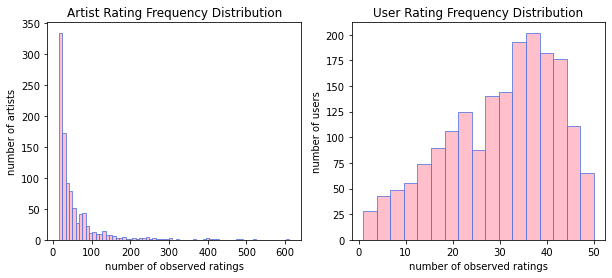

In [26]:
# Da bismo ispitali izbalansiranost podataka kreiramo histograme za korisnike koji su dodijelili rejting
# i za izvođače kojima je dodijeljen rejting. 
# Određujemo prvo frekvenciju dodijeljenih tagova od strane korisnika. 
userID, rate_frequency_user = np.unique(df_user_artists['userID'], return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax1.hist(most_frequent_artists['rate_frequency_artist'], bins = 'auto', edgecolor='royalblue', color='pink',\
        linewidth = 0.7)
ax1.set_title('Artist Rating Frequency Distribution')
ax1.set_xlabel('number of observed ratings')
ax1.set_ylabel('number of artists')

ax2.hist(rate_frequency_user, bins = 'auto', edgecolor='royalblue', color='pink', \
        linewidth = 0.7)
ax2.set_title('User Rating Frequency Distribution')
ax2.set_xlabel('number of observed ratings')               
ax2.set_ylabel('number of users')

plt.show()

<div style="text-align: justify"> Posmatrajući histograme uočavamo da su frekvencije ocijenjenih izvođača izbalansirane, jer većina izvođača ima slične frekvencije.
Sa druge strane, frekvencije ocjena korisnika značajno variraju. Ovo opažanje je donekle očekivano, jer korisnik može dati više različitih tagova različitim izvođačima, odnosno može da ocijeni veliki broj izvođača, ali može da ocijeni i samo jednog. </div>

Stoga, zaključujemo da se za naš skup podataka vezuju dva ključna problema: 
* nedostatak podataka,
* neizbalansiranost podataka.

In [27]:
print(len(df_user_artists[df_user_artists['weight'] > 5000]))

1300


<div style="text-align: justify"> Nadalje, uočavamo da je raspodjela izdvojenih 56620 rejtinga veoma asimetrična. Samo 1300 rejtinga su veći od 5000. 
To možemo vidjeti i na grafiku u nastavku, dolje, lijevo. Da bismo riješili ovaj problem odlučujemo se za logaritamsku transformaciju rejtinga, odnosno za rejtinge uzimamo logaritam kolone 'listening count'. Grafik prikazuje raspodjelu rejtinga prije i poslije primjene logaritamske transformacije. Možemo primijetiti da je raspodjela rejtinga približno log-normalna. </div>

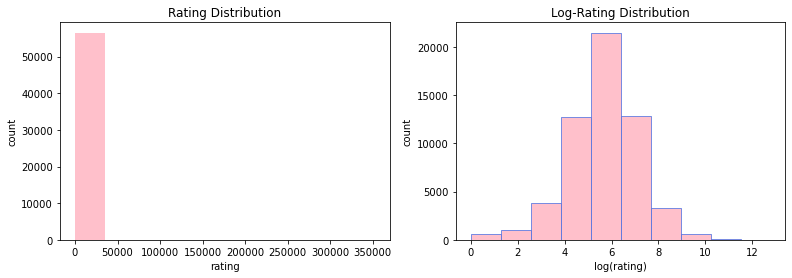

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 4)
ax1.hist(df_user_artists['weight'], color='pink')
ax1.set_title('Rating Distribution')
ax1.set_xlabel('rating')
ax1.set_ylabel('count')

ax2.hist(np.log(df_user_artists['weight']), edgecolor='royalblue', color='pink', \
        linewidth = 0.7)
ax2.set_title('Log-Rating Distribution')
ax2.set_xlabel('log(rating)')               
ax2.set_ylabel('count')

plt.show()